In [ ]:
!pip install tensorflow.io
!pip install tensorflow-gpu
!pip install tensorflow-datasets

In [1]:
#@title # Imports {display-mode: "form"}

# Upgrade tensorflow to latest stable version

import json
import zipfile
import os
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktrans

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
#@title # Prepare data {display-mode: "form"}
#@markdown Set the batch size:

batch_size = 64 #@param {type:"slider", min:8, max:128, step:8}

def crop_resize_normalize(item):
    """Use this function as first mapping to raw dataset.
    
    This function gets items from tensorflow celeb_a dataset one-by-one,
     and crops the face in image based on landmarks, then resizes the cropped
     face to (128, 128) and normalizes that to (0, 1). At return, returns whole
     item with image replaces by new generated face.
    """
    img = item['image']

    # Normalize and resize image
    resized = tf.image.resize(tf.cast(img, tf.float32) / 255.0, [128, 128])
    item['image'] = resized
    return item


def preprocess(image):
    # Returns image, image because when training, vae expects same input image as output
    image = image['image']
    return image, image

def preprocess_test(image):
    return image['image']

# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[:5%]')
train_data, val_data, test_data = data, data, data

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/480000 [00:00<?, ? examples/s]

Shuffling shapes3d-train.tfrecord...:   0%|          | 0/480000 [00:00<?, ? examples/s]

Dataset shapes3d downloaded and prepared to /home/ec2-user/tensorflow_datasets/shapes3d/2.0.0. Subsequent calls will reuse this data.


In [4]:
info.splits['train'].num_examples

480000

In [5]:
def encoder_network(input_shape, latent_dim=100):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon_mean = 0
        epsilon_std = 1.0
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=epsilon_mean, stddev=epsilon_std)
        sampled_z = z_mean + K.exp(z_log_var / 2) * epsilon
        return sampled_z
    
    input_img = Input(shape=input_shape)
    x = Conv2D(32, 4, strides=(2, 2))(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = GlobalAveragePooling2D()(x)

    z_mean = Dense(latent_dim, name='mean')(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(input_img, z)
    return encoder, z_mean, z_log_var

def decoder_network(latent_dim=100):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4096)(decoder_input)
    x = Reshape((4, 4, 256))(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = Model(decoder_input, x)
    return decoder

def perceptual_loss(x, z_decoded):
    h1_list = model(x)
    h2_list = model(z_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.mean(K.sum(K.square(h1 - h2), axis=-1))
    return rc_loss

def perceptual_corr_loss(x, z_decoded):
    h1_list = model(x)
    h2_list = model(z_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        
        mean_1 = tf.reduce_mean(h1, axis=-1)
        mean_2 = tf.reduce_mean(h2, axis=-1)
        h1 = tf.subtract(h1, tf.expand_dims(mean_1, 1))
        h2 = tf.subtract(h2, tf.expand_dims(mean_2, 1))
        h = tf.multiply(h1, h2)
        numerator = tf.reduce_mean(h, axis=-1)
        denominator = K.std(h1, axis=-1) * K.std(h2, axis=-1)
        if denominator == 0:
            continue
        else:
            rc_loss = rc_loss + weight * tf.reduce_mean(numerator / denominator)
    return rc_loss

def kl_loss():
    kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                      - K.square(z_mean) \
                      - K.exp(z_log_var), axis=-1))
    return kl

def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain VAE'''
    return K.mean(K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1))

def vae_loss(x, z_decoded):
    '''Total loss for the DFC VAE'''
    return 5e-1 * reconstruction_loss(x, z_decoded) + kl_loss()
  
def vae_dfc_loss(x, z_decoded):
    '''Total loss for the DFC VAE'''
    return 5e-1 * perceptual_loss(x, z_decoded) + kl_loss()

### Train and test models

In [ ]:
latent_dim = 100 
epochs = 1 

input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
z_encoded = encoder.output
decoder = decoder_network(latent_dim)
z_decoded = decoder(z_encoded)

vae = Model(encoder.input, z_decoded)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

vae.compile(optimizer=opt, loss=vae_loss)

train_iterator = tf.compat.v1.data.make_one_shot_iterator(train_ds)
val_iterator = tf.compat.v1.data.make_one_shot_iterator(val_ds)

vae.fit(train_ds.shuffle(1000),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=validation_steps)

In [ ]:
encoder.save_weights("encoder-shapes.h5")
decoder.save_weights("decoder-shapes.h5")

### Use trained model

#### Can model recall seen images?

In [6]:
latent_dim = 100 
input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
decoder = decoder_network(latent_dim)

encoder.load_weights("encoder-shapes.h5")
decoder.load_weights("decoder-shapes.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0   

In [8]:
encoder.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[:5%]')
train_data, val_data, test_data = data, data, data

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)

In [10]:
#@title # Test plain vae {display-mode: "form"}

n = 10
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


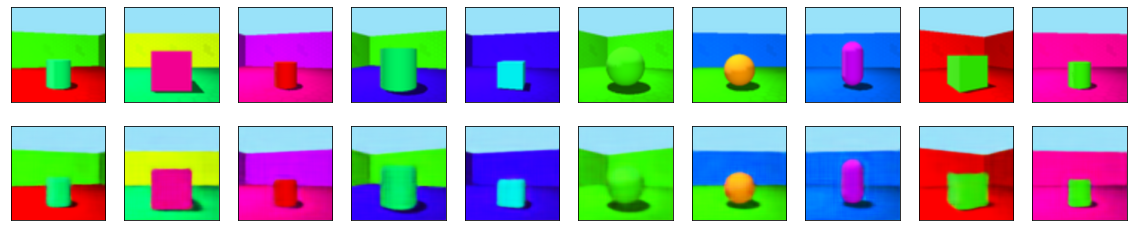

In [11]:
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### What does the model do with unseen images?

In [12]:
# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[10%:15%]')
train_data, val_data, test_data = data, data, data

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)

In [13]:
#@title # Test plain vae {display-mode: "form"}

n = 10
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

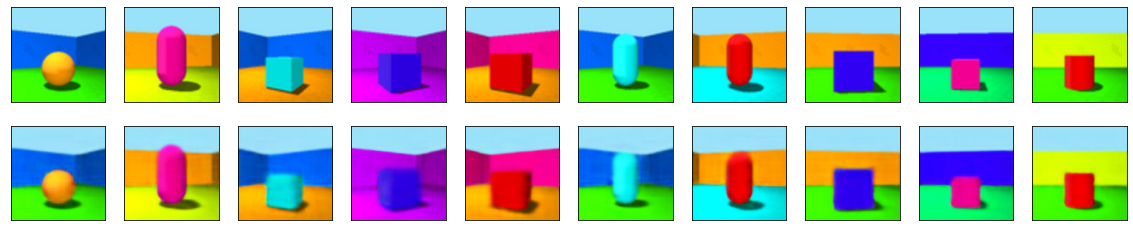

In [14]:
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Can the model generate new images?

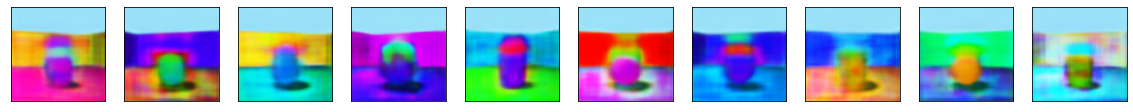

In [15]:
encoded_imgs = np.random.uniform(low=-1, high=1, size=(10,100))

decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Can the model vary an image in different directions?

In [16]:
n = 10
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

encoded_imgs[0:1].shape

(1, 100)

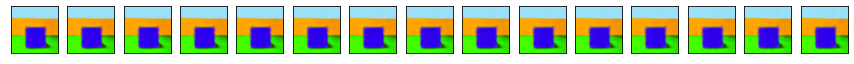

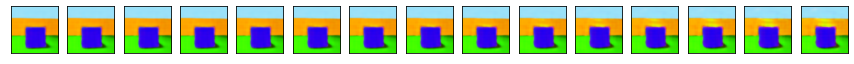

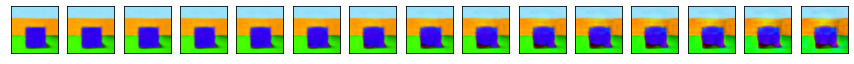

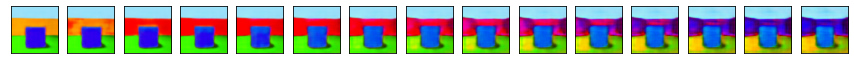

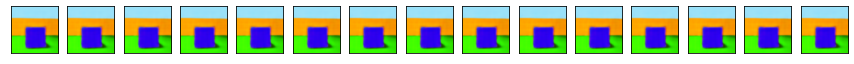

In [17]:
def vary_img(latent_im, ind, amount):
    new_latent_im = np.copy(latent_im)
    new_latent_im[0,ind] = new_latent_im[0,ind] + amount
    return new_latent_im

for i in range(5):
    
    varied = encoded_imgs[7:8]
    plt.figure(figsize=(15, 1))
    
    for j in range(15):
        ax = plt.subplot(1, 15, j+1)
        varied = vary_img(varied, i, 1)
        decoded_imgs = decoder.predict(varied)
        ax.imshow(decoded_imgs[0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Can model interpolate between two images?

In [18]:
from scipy.interpolate import interp1d

def interpolate_ims(first, second):

    enc1 = encoded_imgs[first:first+1]
    enc2 = encoded_imgs[second:second+1]

    linfit = interp1d([1,10], np.vstack([enc1, enc2]), axis=0)

    plt.figure(figsize=(20, 5))

    for j in range(10):
        ax = plt.subplot(1, 10, j+1)
        decoded_imgs = decoder.predict(np.array(linfit(j+1)).reshape(1,100))
        ax.imshow(decoded_imgs[0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

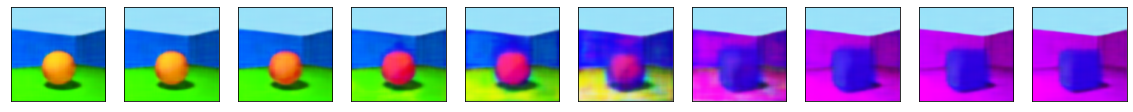

In [19]:
interpolate_ims(0,3)

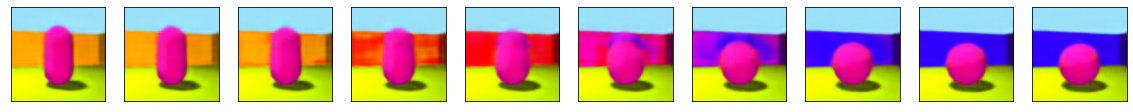

In [20]:
interpolate_ims(1,10)

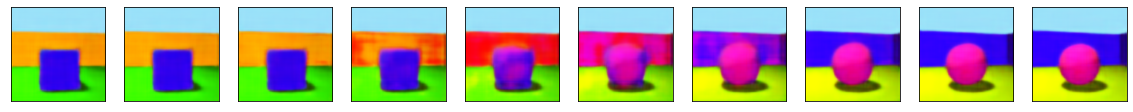

In [21]:
interpolate_ims(7,10)

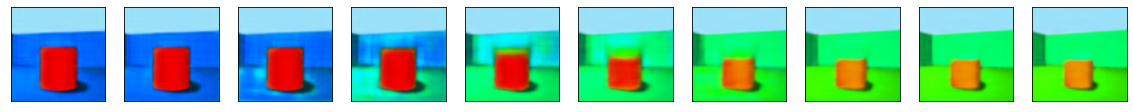

In [22]:
interpolate_ims(12,14)

### Can model recall an image from a noisy input?

In [23]:
from PIL import Image, ImageOps

def add_noise(im_as_array):
    img = Image.fromarray((im_as_array*255).astype(np.uint8))
    gaussian = np.random.normal(0, 100, (img.size[0],img.size[1], 3))
    noisy_img = img + gaussian
    return np.array(noisy_img) / 255

def remove_border(im_as_array):
    img = Image.fromarray((im_as_array*255).astype(np.uint8))
    im_crop = ImageOps.crop(img, border=10)
    new_im = ImageOps.expand(im_crop,border=10,fill='black')
    return np.array(new_im) / 255

def rotate_im(im_as_array):
    img = Image.fromarray((im_as_array*255).astype(np.uint8))
    return np.array(img.rotate(10)) / 255

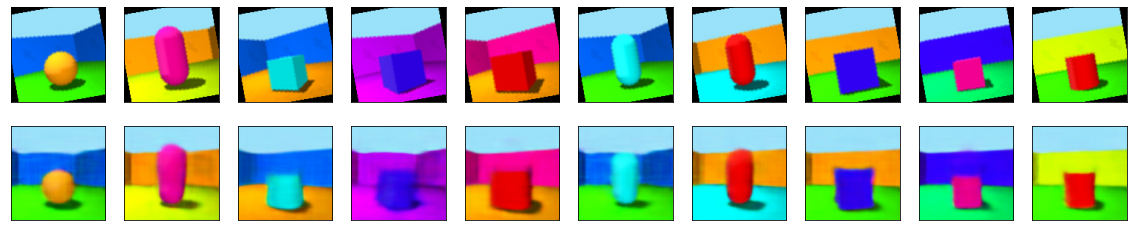

In [24]:
x_test_new = np.array([rotate_im(image) for image in x_test])

encoded_imgs = code.predict(x_test_new)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_new[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

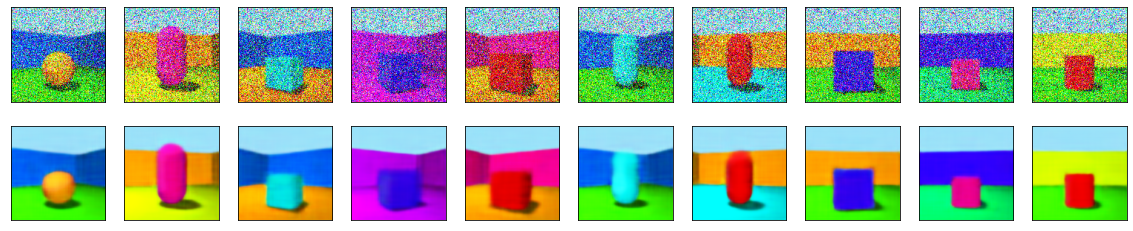

In [25]:
x_test_new = np.array([add_noise(image) for image in x_test])

encoded_imgs = code.predict(x_test_new)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_new[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

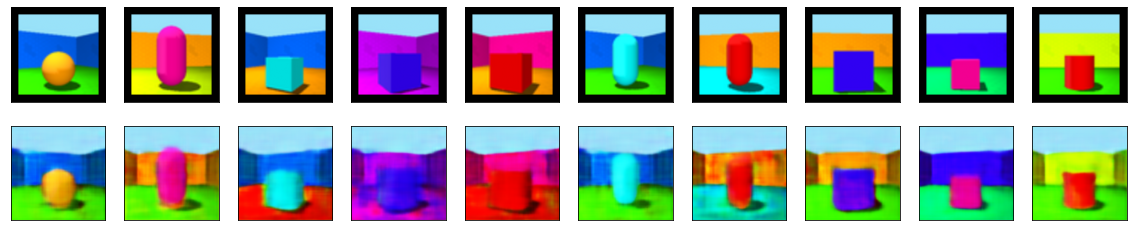

In [26]:
x_test_new = np.array([remove_border(image) for image in x_test])

encoded_imgs = code.predict(x_test_new)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_new[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### classification from latent variables

In [94]:
def preprocess(image):
    return image['image']

def get_shape(item):
    return item['value_shape']
    #return item['label_object_hue']

# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[10%:15%]')
train_data, val_data, test_data = data, data, data

batch_size=1000

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
test_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
shapes = train_data.map(get_shape).batch(batch_size).prefetch(1)

In [95]:
n = 1000
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

In [96]:
n = 1000
generator = tf.compat.v1.data.make_one_shot_iterator(shapes)
shapes = generator.get_next()
shapes = tfds.as_numpy(shapes)

In [97]:
encoded_imgs = code.predict(x_test)

In [98]:
encoded_imgs[0].shape

(100,)

In [102]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(encoded_imgs, shapes, 
                                                    test_size=0.5, random_state=1)
num_examples = [10,20,30,40,50,100,200,300,400,500]
scores = []

for num in num_examples:
    #clf = MLPClassifier(hidden_layer_sizes=50)
    clf = SVC(C=10)
    clf.fit(X_train[0:num], y_train[0:num])
    score = clf.score(X_test, y_test)
    scores.append(score)

In [103]:
scores

[0.412, 0.556, 0.646, 0.724, 0.79, 0.876, 0.962, 0.976, 0.992, 0.996]

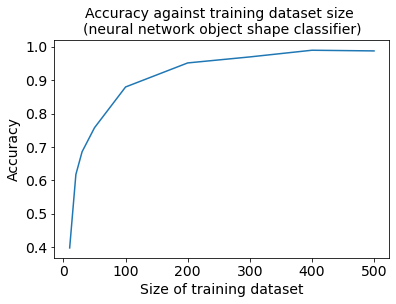

In [101]:
import matplotlib.pyplot as plt
plt.plot(num_examples, scores)
plt.xlabel('Size of training dataset', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy against training dataset size \n(neural network object shape classifier)', fontsize=14)
#plt.savefig('MLP_shape.png', bbox_inches='tight')

### Denoise images

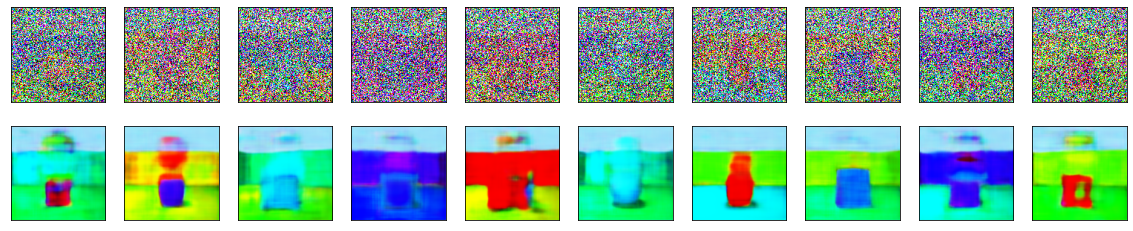

In [108]:
def add_noise(im_as_array):
    img = Image.fromarray((im_as_array*255).astype(np.uint8))
    gaussian = np.random.normal(0, 600, (img.size[0],img.size[1], 3))
    noisy_img = img + gaussian
    return np.array(noisy_img) / 255

x_test_new = np.array([add_noise(image) for image in x_test])

encoded_imgs = code.predict(x_test_new)
decoded_imgs = decoder.predict(encoded_imgs)

n=10
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_new[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()